In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
print(label_data.shape)
label_data = label_data.drop(['index'], axis=1)
label_data.head()

(101, 2)


,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [4]:
print(label_data.shape)


(101, 1)


In [5]:
#Total Number of video folders for classification
len(label_data)

101

In [6]:
path=[]
for label in label_data.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

'../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/'

In [7]:
print(len(path))

101


In [9]:
UCF101_frames = '/kaggle/working/UCF101_frames'

In [10]:
#Function for loading video files, Process and store in a data set
def saving_the_frames(datasets):
    if not os.path.exists(UCF101_frames):
            os.mkdir(UCF101_frames)
    
    
    #Iterate through each fodler corresponding to category
    folders = os.listdir(datasets)
#     (folders)
#each class_name is one folder example ApplyEyeMakeup
    for class_name in folders:
#         print(class_name)
        image_folder_path = os.path.join('/kaggle/working/UCF101_frames',class_name)
#         print(image_folder_path)
        if not os.path.exists(image_folder_path):
            os.mkdir(image_folder_path)
        video_path =  os.path.join('/kaggle/input/ucf101/UCF101/UCF-101',class_name)
#         print(video_path)
        
        for video_file_name in os.listdir(video_path):
#             print(video_file_name)
            if '.avi' not in video_file_name:
                continue
            name, ext = os.path.splitext(video_file_name)
#             print(name)
            video_frame_folder_path = os.path.join(image_folder_path,name)
#             print(video_frame_folder_path)
            if not os.path.exists(video_frame_folder_path):
                os.mkdir(video_frame_folder_path)

In [11]:
saving_the_frames('/kaggle/input/ucf101/UCF101/UCF-101')

In [22]:
from PIL import Image

#Function for Feature Extraction
def feature_extraction(video_path):
    width=80
    height=60
    sequence_length=15
    frames_list=[]
    
    name, ext = os.path.splitext(video_path)
    video_name=os.path.basename(name)
    folderName =os.path.dirname(video_path)
    file_name = os.path.basename(folderName)
    #fileName is folder name i.e. class name
#     print(file_name)
#     print(video_path)
    #print(a)
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        
        if not ret:
            break;
        #Resize the image
#         frame=cv2.resize(frame, (height, width))
#        print(frame.shape)
        #frame = frame/255
        #Append to the frame
        frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frames_list.append(frame)
        array=np.array(frame)
        new_image = Image.fromarray(array)
        new_image.save('/kaggle/working/UCF101_frames/'+file_name+'/'+video_name
                       +'/'+video_name+str(counter)+'.png')
#         print(len(frames_list))
    video_reader.release()
    #Return the Frames List
    return frames_list

In [23]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    
    #Iterate through each foler corresponding to category
    for folder in datasets:
        print(folder)
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='float16')

In [24]:
#Due to memory allocation problem. I will select first 10 folders for classification
images, labels = load_video(path[0:3])

../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/


100%|██████████| 145/145 [01:30<00:00,  1.60it/s]


../input/ucf101/UCF101/UCF-101/ApplyLipstick/


100%|██████████| 114/114 [01:13<00:00,  1.56it/s]


../input/ucf101/UCF101/UCF-101/Archery/


100%|██████████| 145/145 [01:35<00:00,  1.51it/s]


In [33]:
for root, dirs, files in os.walk('/kaggle/working/UCF101_frames/'):
    f = os.path.basename(root) 
#     if(len(files)>0):
#         print(files)
   

In [29]:
print(images.shape)

(404, 15, 240, 320, 3)


In [34]:
#Shapes
images.shape, pd.Series(labels).shape
print(labels[300])

2.0


In [36]:
print(type(images[0][0][0][0][0]))
print(images[0][0].shape)

<class 'numpy.float16'>
(240, 320, 3)


In [38]:
def merging_frames(frames):
    frames1 = frames[0]
    frames2 = frames[1]
    frames3 = frames[2]
    frames4 = frames[3]
    frames5 = frames[4]
    merged_image = frames1+frames2+frames3+frames4+frames5
#     print(frames1)
    merged_image=merged_image/5.0
    return merged_image

In [39]:
all_input=[]
all_labels=[]
for category,label in zip(images,labels):
#     print(label)
    #category is list of 15 frames
    im1=merging_frames(category[0:5])
    im2=merging_frames(category[5:10])
    im3=merging_frames(category[10:15])
    all_input.append(im1)
    all_input.append(im2)
    all_input.append(im3)
    all_labels.append(label)
    all_labels.append(label)
    all_labels.append(label)
print(len(all_labels))
    

1212


In [43]:
print(len(all_input))
print(len(all_labels))

1212
1212


In [44]:
a=all_input[999]
print(a)

[[[229.8 241.8 232.8]
  [231.6 243.6 234.6]
  [239.8 250.8 249.8]
  ...
  [252.  250.  251. ]
  [255.  255.  255. ]
  [184.  182.  183. ]]

 [[243.4 254.6 246.4]
  [238.2 250.2 241.2]
  [235.2 246.2 245.2]
  ...
  [252.  250.  251. ]
  [254.  252.  253. ]
  [181.  179.  180. ]]

 [[239.2 255.  246.2]
  [236.6 253.6 243.6]
  [239.6 254.6 253.2]
  ...
  [250.  252.  252. ]
  [253.  255.  255. ]
  [178.  180.  180. ]]

 ...

 [[ 87.   88.   78. ]
  [ 73.   74.   64. ]
  [ 68.   67.   58. ]
  ...
  [182.2 169.2 148.2]
  [168.4 155.4 132.4]
  [119.4 106.4  83.4]]

 [[ 80.   79.   70. ]
  [ 67.   66.   57. ]
  [ 61.   60.   51. ]
  ...
  [111.2 102.2  85.2]
  [107.4  98.4  81.4]
  [ 78.4  69.4  52.4]]

 [[ 13.   12.    3. ]
  [  1.    0.    0. ]
  [  1.    0.    0. ]
  ...
  [ 16.8   7.8   0. ]
  [ 24.6  15.6   0. ]
  [ 14.4   5.4   0. ]]]


In [45]:
print(type(a[1][0][0]))
a=np.rint(a)
a = a.astype(np.int32)

<class 'numpy.float16'>


In [46]:
print(type(a[1][0][0]))
print(a)

<class 'numpy.int32'>
[[[230 242 233]
  [232 244 235]
  [240 251 250]
  ...
  [252 250 251]
  [255 255 255]
  [184 182 183]]

 [[243 255 246]
  [238 250 241]
  [235 246 245]
  ...
  [252 250 251]
  [254 252 253]
  [181 179 180]]

 [[239 255 246]
  [237 254 244]
  [240 255 253]
  ...
  [250 252 252]
  [253 255 255]
  [178 180 180]]

 ...

 [[ 87  88  78]
  [ 73  74  64]
  [ 68  67  58]
  ...
  [182 169 148]
  [168 155 132]
  [119 106  83]]

 [[ 80  79  70]
  [ 67  66  57]
  [ 61  60  51]
  ...
  [111 102  85]
  [107  98  81]
  [ 78  69  52]]

 [[ 13  12   3]
  [  1   0   0]
  [  1   0   0]
  ...
  [ 17   8   0]
  [ 25  16   0]
  [ 14   5   0]]]


In [25]:
# dynamic_images = '/kaggle/working/dynamic_images'
# if not os.path.exists(dynamic_images):
#     os.mkdir(dynamic_images)  
            

ls

In [48]:
rm adynamic*

In [47]:
dynamic_images = '/kaggle/working/dynamic_images'

In [48]:
if not os.path.exists(dynamic_images):
    os.mkdir(dynamic_images)

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
count = 0
for dynamic_image in all_input:
    count = count + 1
    a = dynamic_image
    a=np.rint(a)
    a = a.astype(np.int32)
    an = np.array(a.astype('uint8'))
    an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
#     if(count%100==0) :
#         plt.imshow(a)
#         plt.show()
    
    cv2.imwrite('/kaggle/working/dynamic_images/dynamic_image'+str(count)+'.png',an)
    
    

In [53]:
for root, dirs, files in os.walk('/kaggle/working/dynamic_images/'):
    f = os.path.basename(root) 
    print(len(files))
    print(files)

1212
['dynamic_image401.png', 'dynamic_image829.png', 'dynamic_image547.png', 'dynamic_image714.png', 'dynamic_image454.png', 'dynamic_image1015.png', 'dynamic_image670.png', 'dynamic_image605.png', 'dynamic_image996.png', 'dynamic_image593.png', 'dynamic_image922.png', 'dynamic_image559.png', 'dynamic_image631.png', 'dynamic_image173.png', 'dynamic_image700.png', 'dynamic_image796.png', 'dynamic_image1107.png', 'dynamic_image731.png', 'dynamic_image964.png', 'dynamic_image495.png', 'dynamic_image258.png', 'dynamic_image343.png', 'dynamic_image69.png', 'dynamic_image954.png', 'dynamic_image364.png', 'dynamic_image945.png', 'dynamic_image719.png', 'dynamic_image630.png', 'dynamic_image1162.png', 'dynamic_image288.png', 'dynamic_image1066.png', 'dynamic_image868.png', 'dynamic_image115.png', 'dynamic_image518.png', 'dynamic_image591.png', 'dynamic_image1059.png', 'dynamic_image188.png', 'dynamic_image409.png', 'dynamic_image153.png', 'dynamic_image930.png', 'dynamic_image46.png', 'dynami

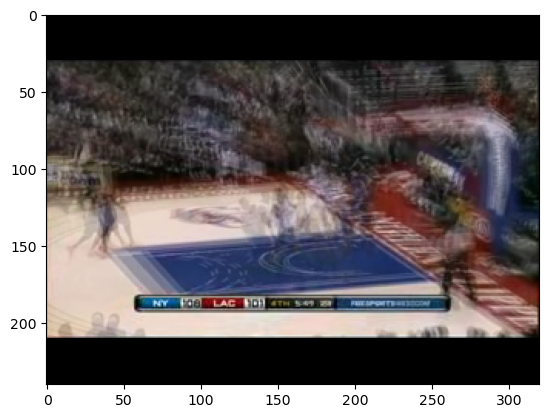

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
an = np.array(a.astype('uint8'))
an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()
plt.savefig('random.png')

In [26]:
print(all_labels[1500])

3.0


In [73]:

#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(all_input, all_labels, test_size=0.06, random_state=10)
x_train=np.array(x_train)
x_test=np.array(x_test)
x_train.shape,x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((730, 240, 320, 3), (47, 240, 320, 3), (730,), (47,))

In [122]:
print(x_train.shape)
print(x_train[0][0].shape)
print(y_train[0])


(730, 240, 320, 3)
(320, 3)
0.0


In [124]:
print(type(x_train[0][0][0][0]))

<class 'numpy.float16'>


In [54]:
!zip -r dynamic_images.zip /kaggle/working/dynamic_images

  adding: kaggle/working/dynamic_images/ (stored 0%)
  adding: kaggle/working/dynamic_images/dynamic_image401.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image829.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image547.png (deflated 5%)
  adding: kaggle/working/dynamic_images/dynamic_image714.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image454.png (deflated 7%)
  adding: kaggle/working/dynamic_images/dynamic_image1015.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image670.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image605.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image996.png (deflated 5%)
  adding: kaggle/working/dynamic_images/dynamic_image593.png (deflated 2%)
  adding: kaggle/working/dynamic_images/dynamic_image922.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynamic_image559.png (deflated 3%)
  adding: kaggle/working/dynamic_images/dynami